<a href="https://colab.research.google.com/github/SibusisoTL/healthcare_startup_hospital_visits/blob/main/hospitalvisits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Healthcare Startup Hospital Visits
##Predicting Patient Readmission Rates
This project aims to develop a machine learning model to predict patient readmission rates within 30 days of discharge using historical patient data. By leveraging Python's extensive libraries and machine learning frameworks, the model will help hospitals reduce unnecessary readmissions, saving costs and improving patient care.

Key steps involved:

*   Data Preprocessing: Cleaning and preparing the dataset.
*   Exploratory Data Analysis: Understanding the data through visualization and statistical analysis.
*   Feature Selection: Identifying the most relevant features.
*   Model Building: Developing the predictive model.
*   Model Evaluation: Assessing the model's performance.

The ultimate goal is to provide valuable insights to healthcare providers, enhancing patient care and operational efficiency.

In [163]:
import os
import altair as alt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [164]:
# LOAD DATA ONCE
#@st.cache_resource
def load_data():
    path = "Expanded_Patient_Readmission_Data.csv"
    if not os.path.isfile(path):
        path = f"https://github.com/SibusisoTL/healthcare_startup_hospital_visits/raw/main/{path}"

    data = pd.read_csv(
        path
    )

    return data

##1. Data Preprocessing and Cleanup



In [165]:
import pandas as pd
path = "Expanded_Patient_Readmission_Data.csv"
url = f"https://github.com/SibusisoTL/healthcare_startup_hospital_visits/raw/main/{path}"
df = pd.read_csv(url)


df.head(5)

,Patient ID,Age,Gender,Admission Type,Length of Stay,Number of Diagnoses,Blood Pressure,Blood Sugar Levels,Previous Admissions,Readmission
0,1,62,Female,Elective,4,5,110,130,1,No
1,2,65,Male,Emergency,19,2,157,81,4,No
2,3,82,Female,Emergency,18,4,74,84,0,No
3,4,85,Male,Emergency,2,4,106,85,4,No
4,5,85,Female,Elective,19,3,80,119,3,No


In [166]:
df.columns

Index(['Patient ID', 'Age', 'Gender', 'Admission Type', 'Length of Stay',
       'Number of Diagnoses', 'Blood Pressure', 'Blood Sugar Levels',
       'Previous Admissions', 'Readmission'],
      dtype='object')

In [167]:

df = df.rename(columns={
    'Patient ID': 'patient_id',
    'Age': 'age',
    'Gender': 'gender',
    'Admission Type' : 'admission_type',
    'Length of Stay': 'length_of_stay',
    'Number of Diagnoses': 'number_of_diagnoses',
    'Blood Pressure': 'blood_pressure',
    'Blood Sugar Levels': 'blood_sugar_levels',
    'Previous Admissions': 'previous_admissions',
    'Readmission': 'readmission'

})

In [168]:
df.head()

,patient_id,age,gender,admission_type,length_of_stay,number_of_diagnoses,blood_pressure,blood_sugar_levels,previous_admissions,readmission
0,1,62,Female,Elective,4,5,110,130,1,No
1,2,65,Male,Emergency,19,2,157,81,4,No
2,3,82,Female,Emergency,18,4,74,84,0,No
3,4,85,Male,Emergency,2,4,106,85,4,No
4,5,85,Female,Elective,19,3,80,119,3,No


In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   patient_id           3000 non-null   int64 
 1   age                  3000 non-null   int64 
 2   gender               3000 non-null   object
 3   admission_type       3000 non-null   object
 4   length_of_stay       3000 non-null   int64 
 5   number_of_diagnoses  3000 non-null   int64 
 6   blood_pressure       3000 non-null   int64 
 7   blood_sugar_levels   3000 non-null   int64 
 8   previous_admissions  3000 non-null   int64 
 9   readmission          3000 non-null   object
dtypes: int64(7), object(3)
memory usage: 234.5+ KB


In [170]:
def categorize_age(age):
    if age <= 18:
        return 'childhood'
    elif 19 <= age <= 35:
        return 'young_adults' #(peak health, less chronic illness)
    elif 36 <= age <= 50:
        return 'mid-life' #(onset of chronic conditions)
    elif 51 <= age <= 70:
        return 'older_adults' #(increased health risks)
    else:
      return 'elderly' #(high risk of chronic conditions)

# Apply the categorization function to the 'Age' column
df['age_category'] = df['age'].apply(categorize_age)

# Insert 'Age Category' column at column index 2 (3rd position)
df.insert(2, 'age_category', df.pop('age_category'))


In [171]:
df.head()

,patient_id,age,age_category,gender,admission_type,length_of_stay,number_of_diagnoses,blood_pressure,blood_sugar_levels,previous_admissions,readmission
0,1,62,older_adults,Female,Elective,4,5,110,130,1,No
1,2,65,older_adults,Male,Emergency,19,2,157,81,4,No
2,3,82,elderly,Female,Emergency,18,4,74,84,0,No
3,4,85,elderly,Male,Emergency,2,4,106,85,4,No
4,5,85,elderly,Female,Elective,19,3,80,119,3,No


In [172]:
df.age_category.unique()

array(['older_adults', 'elderly', 'young_adults', 'mid-life', 'childhood'],
      dtype=object)

##2. Exploratory Data Analysis and Insights

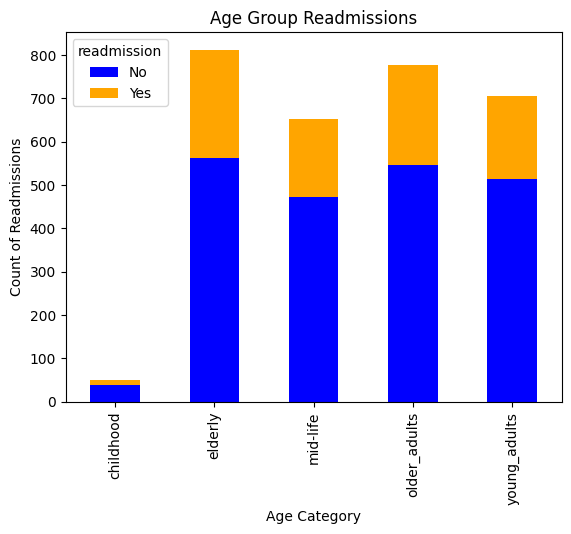

In [173]:
# Group by 'age_category' and 'readmission' to count occurrences
age_readmission_counts = df.groupby(['age_category', 'readmission']).size().unstack()

# Plotting the bar chart
age_readmission_counts.plot(kind='bar', stacked=True, color=['blue', 'orange'])

# Add titles and labels
plt.title('Age Group Readmissions')
plt.xlabel('Age Category')
plt.ylabel('Count of Readmissions')

# Show the plot
plt.show()

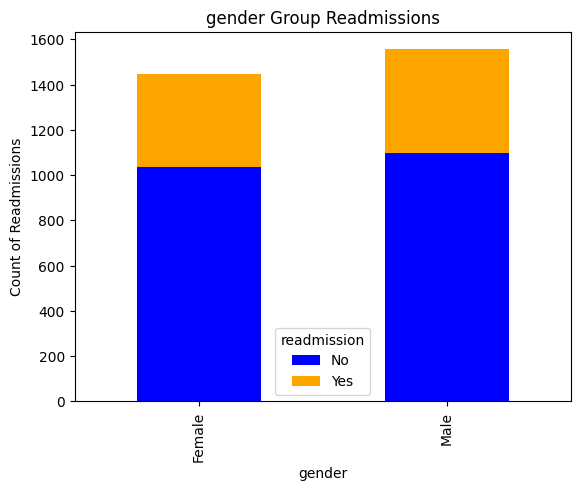

In [174]:
# Group by 'Gender_category' and 'readmission' to count occurrences
gender_readmission_counts = df.groupby(['gender', 'readmission']).size().unstack()

# Plotting the bar chart
gender_readmission_counts.plot(kind='bar', stacked=True, color=['blue', 'orange'])

# Add titles and labels
plt.title('gender Group Readmissions')
plt.xlabel('gender')
plt.ylabel('Count of Readmissions')

# Show the plot
plt.show()

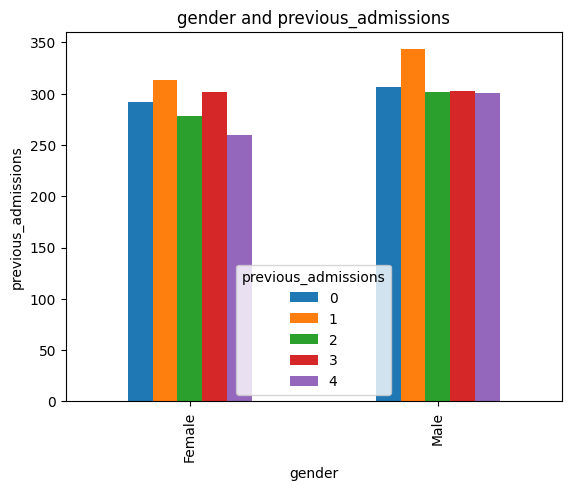

In [175]:
# Group by 'Gender_category' and 'previous_admissions' to count occurrences
gender_readmission_counts = df.groupby(['gender', 'previous_admissions']).size().unstack()

# Plotting the bar chart
gender_readmission_counts.plot(kind='bar')

# Add titles and labels
plt.title('gender and previous_admissions')
plt.xlabel('gender')
plt.ylabel('previous_admissions')

# Show the plot
plt.show()

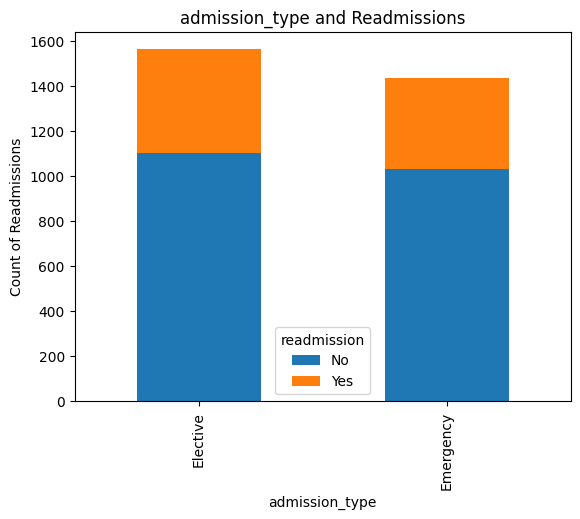

In [176]:
# Group by 'aadmission_type' and 'readmission' to count occurrences
admission_type_readmission_counts = df.groupby(['admission_type', 'readmission']).size().unstack()

# Plotting the bar chart
admission_type_readmission_counts.plot(kind='bar', stacked=True)

# Add titles and labels
plt.title('admission_type and Readmissions')
plt.xlabel('admission_type')
plt.ylabel('Count of Readmissions')

# Show the plot
plt.show()


<ipython-input-177-7848bda87d06>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df, x='number_of_diagnoses', y='age_category', inner='stick', palette='Dark2')


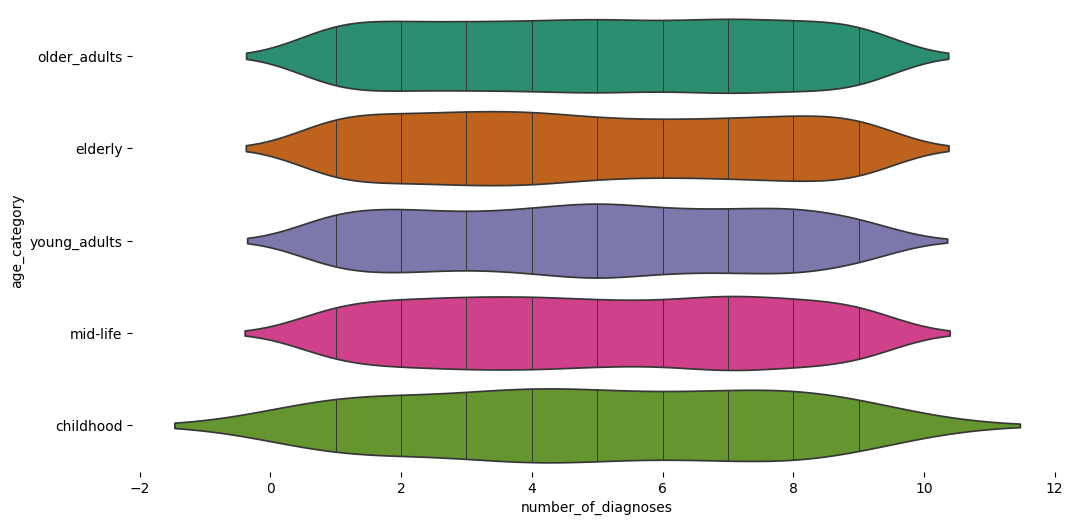

In [177]:

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['age_category'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='number_of_diagnoses', y='age_category', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [178]:
df.head()

,patient_id,age,age_category,gender,admission_type,length_of_stay,number_of_diagnoses,blood_pressure,blood_sugar_levels,previous_admissions,readmission
0,1,62,older_adults,Female,Elective,4,5,110,130,1,No
1,2,65,older_adults,Male,Emergency,19,2,157,81,4,No
2,3,82,elderly,Female,Emergency,18,4,74,84,0,No
3,4,85,elderly,Male,Emergency,2,4,106,85,4,No
4,5,85,elderly,Female,Elective,19,3,80,119,3,No


##Feature Selection

In [179]:
# Convert all categorical columns to category codes
df1 = df.copy()
for col in df1.select_dtypes(include='object'):
    df1[col] = df1[col].astype('category').cat.codes


In [180]:
df1.head()

,patient_id,age,age_category,gender,admission_type,length_of_stay,number_of_diagnoses,blood_pressure,blood_sugar_levels,previous_admissions,readmission
0,1,62,3,0,0,4,5,110,130,1,0
1,2,65,3,1,1,19,2,157,81,4,0
2,3,82,1,0,1,18,4,74,84,0,0
3,4,85,1,1,1,2,4,106,85,4,0
4,5,85,1,0,0,19,3,80,119,3,0


In [181]:
#Removing age and Patiend ID columns
df1.drop(['age', 'patient_id'], axis=1, inplace=True)
df1.head()

,age_category,gender,admission_type,length_of_stay,number_of_diagnoses,blood_pressure,blood_sugar_levels,previous_admissions,readmission
0,3,0,0,4,5,110,130,1,0
1,3,1,1,19,2,157,81,4,0
2,1,0,1,18,4,74,84,0,0
3,1,1,1,2,4,106,85,4,0
4,1,0,0,19,3,80,119,3,0


In [182]:
#Selecting freatures and tartget values and splitting data into Train and Test

X = df1.drop(columns='readmission')
y = df1['readmission']

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42, test_size=0.2)

In [183]:
#Model selection process
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

lr.fit(X_train,y_train)

y_pred = lr.predict(X_test)

accuracy_score(y_test,y_pred)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7233333333333334

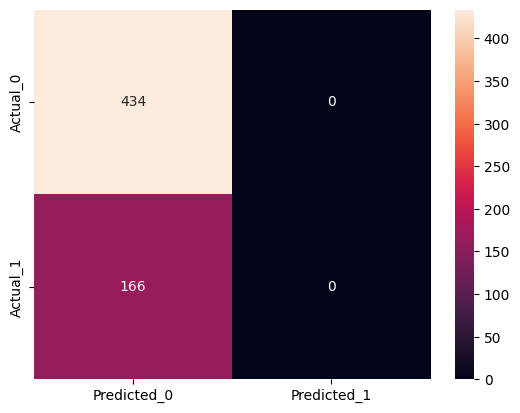

In [184]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
conf = pd.DataFrame(data=cm, columns=['Predicted_0','Predicted_1'], index = ['Actual_0','Actual_1'])
sns.heatmap(conf,annot=True,fmt='d')
plt.show()

In [185]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_pred)

np.float64(0.5)

In [186]:
from sklearn.preprocessing import MinMaxScaler

# Initialize scaler
scaler = MinMaxScaler()

# Select columns to scale
columns_to_scale = ['blood_pressure', 'blood_sugar_levels','length_of_stay']

# Fit and transform only selected columns
df_scaled_values = scaler.fit_transform(df1[columns_to_scale])

# Create a new DataFrame with scaled values and same column names
df_scaled = pd.DataFrame(df_scaled_values, columns=columns_to_scale)

print(df_scaled)


      blood_pressure  blood_sugar_levels  length_of_stay
0           0.420168            0.533784        0.107143
1           0.815126            0.202703        0.642857
2           0.117647            0.222973        0.607143
3           0.386555            0.229730        0.035714
4           0.168067            0.459459        0.642857
...              ...                 ...             ...
2995        0.756303            0.621622        0.107143
2996        0.680672            0.797297        0.000000
2997        0.798319            0.871622        0.035714
2998        0.478992            0.824324        0.428571
2999        0.403361            0.222973        0.892857

[3000 rows x 3 columns]


In [187]:
scaled_values = scaler.fit_transform(df1[columns_to_scale])
scaled_df = pd.DataFrame(scaled_values, columns=[col + '_scaled' for col in columns_to_scale])
scaled_df.head()

,blood_pressure_scaled,blood_sugar_levels_scaled,length_of_stay_scaled
0,0.420168,0.533784,0.107143
1,0.815126,0.202703,0.642857
2,0.117647,0.222973,0.607143
3,0.386555,0.229730,0.035714
4,0.168067,0.459459,0.642857


In [188]:
# Drop original columns from df1
df1 = df1.drop(columns=columns_to_scale)

In [189]:
df1.head()

,age_category,gender,admission_type,number_of_diagnoses,previous_admissions,readmission
0,3,0,0,5,1,0
1,3,1,1,2,4,0
2,1,0,1,4,0,0
3,1,1,1,4,4,0
4,1,0,0,3,3,0


In [190]:
# Concatenate with the original dataframe
df1 = pd.concat([df1, scaled_df], axis=1)

df1.head()


,age_category,gender,admission_type,number_of_diagnoses,previous_admissions,readmission,blood_pressure_scaled,blood_sugar_levels_scaled,length_of_stay_scaled
0,3,0,0,5,1,0,0.420168,0.533784,0.107143
1,3,1,1,2,4,0,0.815126,0.202703,0.642857
2,1,0,1,4,0,0,0.117647,0.222973,0.607143
3,1,1,1,4,4,0,0.386555,0.229730,0.035714
4,1,0,0,3,3,0,0.168067,0.459459,0.642857


In [192]:
#Model selection process
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

lr.fit(X_train,y_train)

y_pred = lr.predict(X_test)

accuracy_score(y_test,y_pred)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7233333333333334